<a href="https://colab.research.google.com/github/takuya-tokumoto/GDL_code/blob/master/colab_pytorch/3%E7%AB%A0_%E5%A4%89%E5%88%86%E3%82%AA%E3%83%BC%E3%83%88%E3%82%A8%E3%83%B3%E3%82%B3%E3%83%BC%E3%83%80_%E3%82%AA%E3%83%BC%E3%83%88%E3%82%A8%E3%83%B3%E3%82%B3%E3%83%BC%E3%83%80(%E7%95%B3%E3%81%BF%E8%BE%BC%E3%81%BF%E5%B1%A4%E3%81%82%E3%82%8A)ver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

【README】  
- オートエンコーダを利用して、手書き文字データから新たな画像を生成
- Pytorchによる実装
- 参考・引用
    - https://atmarkit.itmedia.co.jp/ait/articles/2007/10/news024_2.html

In [24]:
!pip install torchinfo
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST
from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt

In [20]:
def describe_model(model:torch.nn.Module, input_size:tuple, input_data=None):
    if input_data is None:
        summary_str = summary(model,
            input_size=input_size,
            col_names=['input_size', 'output_size', 'num_params', 'kernel_size', 'mult_adds'],
            col_width=18,
            row_settings=['var_names'],
            verbose=1)
    else:
        summary_str = summary(model,
            input_data=input_data,
            col_names=['input_size', 'output_size', 'num_params', 'kernel_size', 'mult_adds'],
            col_width=18,
            row_settings=['var_names'],
            verbose=1)

In [71]:
class Encoder(torch.nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.LeakyReLU = torch.nn.LeakyReLU()
        self.conv_0 = torch.nn.Conv2d(1, 32, kernel_size=3, padding = 'same')
        self.conv_1 = torch.nn.Conv2d(32, 64, kernel_size=3, stride = 2, padding = 1)
        self.conv_2 = torch.nn.Conv2d(64, 64, kernel_size=3, stride = 2, padding = 1)
        self.conv_3 = torch.nn.Conv2d(64, 64,  kernel_size=3, padding = 'same')
        self.linear = torch.nn.Linear(3136, 2)
        self.flatten = torch.nn.Flatten()
    def forward(self, x):
        x = x.reshape(-1, 1, 28, 28)
        x = self.LeakyReLU(self.conv_0(x))
        x = self.LeakyReLU(self.conv_1(x))
        x = self.LeakyReLU(self.conv_2(x))
        x = self.LeakyReLU(self.conv_3(x))
        x = self.flatten(x)
        x = self.linear(x)
        return x

class Decoder(torch.nn.Module):
    def __init__(self, output_size):
        super().__init__()
        self.LeakyReLU = torch.nn.LeakyReLU()
        self.linear1 = torch.nn.Linear(2, 3136)
        self.conv_t_0 = torch.nn.ConvTranspose2d(64, 64, kernel_size=3, stride = 1, padding = 1)
        self.conv_t_1 = torch.nn.ConvTranspose2d(64, 64, kernel_size=2, stride = 2)
        self.conv_t_2 = torch.nn.ConvTranspose2d(64, 32, kernel_size=2, stride = 2)
        self.conv_t_3 = torch.nn.ConvTranspose2d(32, 1, kernel_size=3, stride = 1, padding = 1)
    def forward(self, x):
        x = self.linear1(x)
        x = x.reshape(-1, 64, 7, 7)
        x = self.LeakyReLU(self.conv_t_0(x))
        x = self.LeakyReLU(self.conv_t_1(x))
        x = self.LeakyReLU(self.conv_t_2(x))
        x = self.LeakyReLU(self.conv_t_3(x))
        x = x.reshape(-1, 28*28)
        x = torch.tanh(x) # -1~1に変換
        return x

class AutoEncoder(torch.nn.Module):
    def __init__(self, org_size):
        super().__init__()
        self.enc = Encoder(org_size)
        self.dec = Decoder(org_size)
    def forward(self, x):
        x = self.enc(x) # エンコード
        x = self.dec(x) # デコード
        return x


# class Encoder(torch.nn.Module):
#     def __init__(self, input_size):
#         super().__init__()
#         self.fc1 = torch.nn.Linear(input_size, 512)
#         self.fc2 = torch.nn.Linear(512, 64)
#         self.fc3 = torch.nn.Linear(64, 16)
#         self.fc4 = torch.nn.Linear(16, 2)
#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         x = torch.relu(self.fc3(x))
#         x = self.fc4(x)
#         return x

# class Decoder(torch.nn.Module):
#     def __init__(self, output_size):
#         super().__init__()
#         self.fc1 = torch.nn.Linear(2, 16)
#         self.fc2 = torch.nn.Linear(16, 64)
#         self.fc3 = torch.nn.Linear(64, 512)
#         self.fc4 = torch.nn.Linear(512, output_size)
#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         x = torch.relu(self.fc3(x))
#         x = torch.tanh(self.fc4(x)) # -1~1に変換
#         return x

# class AutoEncoder(torch.nn.Module):
#     def __init__(self, org_size):
#         super().__init__()
#         self.enc = Encoder(org_size)
#         self.dec = Decoder(org_size)
#     def forward(self, x):
#         x = self.enc(x) # エンコード
#         x = self.dec(x) # デコード
#         return x

In [72]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = MNIST('./data', train = True, transform = transform, download = True)
testset = MNIST('./data', train = False, transform = transform, download = True)

batch_size = 50
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle = True)
testloader = DataLoader(testset, batch_size = batch_size, shuffle = True)

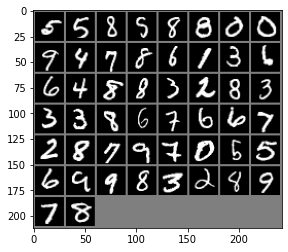

In [73]:
def imshow(img):
    img = torchvision.utils.make_grid(img)
    img = img /2 + 0.5
    nping = img.detach().numpy()
    plt.imshow(np.transpose(nping, (1, 2, 0)))
    plt.show()

iterator = iter(trainloader)
x, _ = next(iterator)
imshow(x)

In [74]:
images, labels = next(iter(trainloader))

model = AutoEncoder(28*28)

describe_model(model, input_size=None, input_data=images)

Layer (type (var_name))                  Input Shape        Output Shape       Param #            Kernel Shape       Mult-Adds
AutoEncoder                              --                 --                 --                 --                 --
├─Encoder (enc)                          [50, 1, 28, 28]    [50, 2]            --                 --                 --
│    └─Conv2d (conv_0)                   [50, 1, 28, 28]    [50, 32, 28, 28]   320                [1, 32, 3, 3]      12,544,000
│    └─LeakyReLU (LeakyReLU)             [50, 32, 28, 28]   [50, 32, 28, 28]   --                 --                 --
│    └─Conv2d (conv_1)                   [50, 32, 28, 28]   [50, 64, 14, 14]   18,496             [32, 64, 3, 3]     181,260,800
│    └─LeakyReLU (LeakyReLU)             [50, 64, 14, 14]   [50, 64, 14, 14]   --                 --                 --
│    └─Conv2d (conv_2)                   [50, 64, 14, 14]   [50, 64, 7, 7]     36,928             [64, 64, 3, 3]     90,473,600
│    └─L

In [75]:
def train(net, criterion, optimaizer, epochs, trainloader):
    losses = []
    output_and_label = []

    for epoch in range(1, epochs + 1):
        print(f'epoch:{epoch}', end = '')
        runnning_loss = 0.0
        for counter, (img, _) in enumerate(trainloader, 1):
            optimizer.zero_grad()
            img = img.reshape(-1, input_size)
            output = net(img)
            loss = criterion(output, img)
            loss.backward()
            optimaizer.step()
            runnning_loss += loss.item()
        avg_loss = runnning_loss / counter
        losses.append(avg_loss)
        print('loss:', avg_loss)
        output_and_label.append((output, img))
    print('finished')
    return output_and_label, losses

input_size = 28 * 28
net = AutoEncoder(input_size)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr = 0.1)
EPOCHS = 10 # 100

output_and_label, losses = train(net, criterion, optimizer, EPOCHS, trainloader)

epoch:1loss: 0.5879147279759248
epoch:2loss: 0.34290711291134357
epoch:3loss: 0.2651832289621234
epoch:4loss: 0.24414115856091181
epoch:5loss: 0.23259286562601725
epoch:6loss: 0.22763142980635165
epoch:7loss: 0.22496396555254858
epoch:8loss: 0.22263566825538875
epoch:9loss: 0.2203295060743888
epoch:10loss: 0.21779794638355573
finished


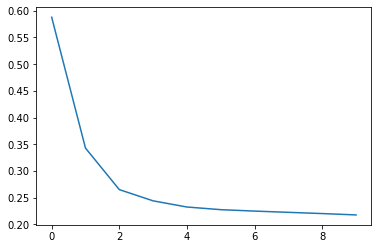

In [76]:
plt.plot(losses)

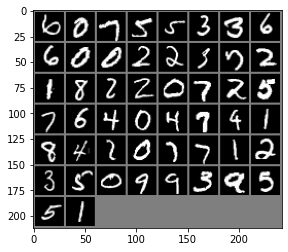

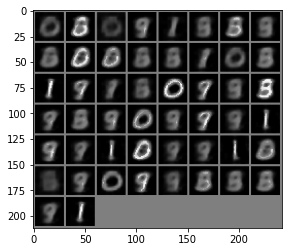

In [77]:
output, org = output_and_label[-1]
imshow(org.reshape(-1, 1, 28, 28))
imshow(output.reshape(-1, 1, 28, 28))

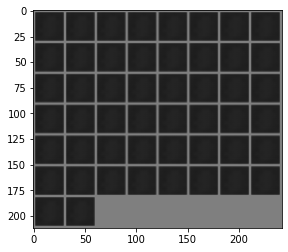

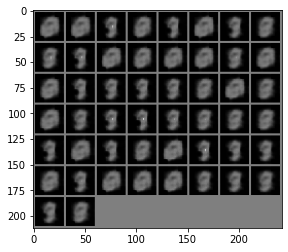

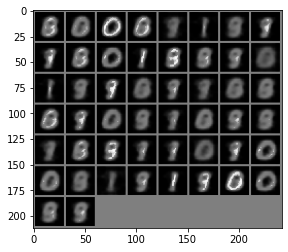

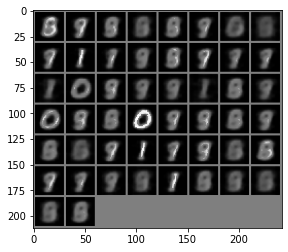

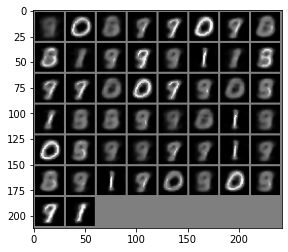

In [78]:
for img, _ in output_and_label[0:10:2]:
    imshow(img.reshape(-1, 1, 28, 28))

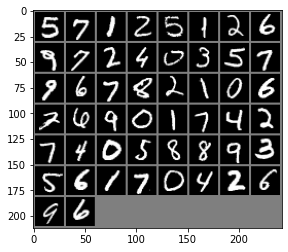

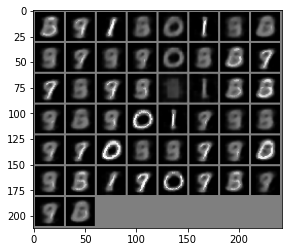

In [79]:
iterator = iter(testloader)
img, _ = next(iterator)
img = img.reshape(-1, 28 *28)
output = net(img)
imshow(img.reshape(-1, 1, 28, 28))
imshow(output.reshape(-1, 1, 28, 28))

In [80]:
sampleloader = DataLoader(testset, batch_size = 1500)
iterator = iter(sampleloader)
img, label = next(iterator)
z = net.enc(img.reshape(-1, 28*28))
z = z.detach().numpy() # 後から簡単に使えるようにするための処理
print(z.shape) # (1500, 2)

(1500, 2)


In [81]:
set_list = [set() for x in range(10)]
for coord, lbl in zip(z.tolist(), label):
    set_list[lbl].add(tuple(coord))

In [82]:
for idx in range(10):
    print(f'items in set_list[{idx}]:')
    for cnt, item in enumerate(set_list[idx]):
        print(item)
        if cnt > 5:
            break

items in set_list[0]:
(36.3270263671875, 6.345717430114746)
(17.56460189819336, 7.959054470062256)
(14.558771133422852, 4.516051769256592)
(20.751548767089844, 20.69857406616211)
(20.4505615234375, 7.165877342224121)
(35.91208267211914, 15.980534553527832)
(35.198307037353516, 0.2766473591327667)
items in set_list[1]:
(-22.726621627807617, 8.706109046936035)
(-23.407257080078125, 0.9650970697402954)
(-22.33768081665039, 7.946070194244385)
(-16.236780166625977, 3.587528944015503)
(-25.811344146728516, 6.473450660705566)
(-20.336477279663086, 6.958467960357666)
(-20.769973754882812, 6.082089900970459)
items in set_list[2]:
(-1.482480764389038, 8.586750984191895)
(0.544914722442627, 20.63394546508789)
(-0.9286599159240723, 20.250566482543945)
(17.412883758544922, 25.766592025756836)
(2.2915103435516357, 5.017296314239502)
(-6.78624963760376, 12.90408992767334)
(4.97631311416626, 0.3488994836807251)
items in set_list[3]:
(-1.9371578693389893, 8.2255277633667)
(10.958284378051758, 17.831010

['0: r', '1: g', '2: b', '3: c', '4: k', '5: y', '6: orange', '7: lightgreen', '8: hotpink', '9: yellow']


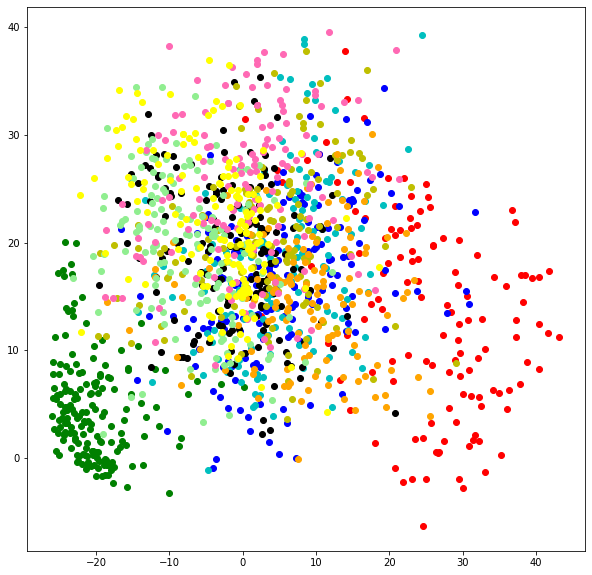

In [83]:
colorlist = ["r", "g", "b", "c", "k", "y", "orange", "lightgreen", "hotpink", "yellow"]
plt.figure(figsize=(10, 10))
for idx in range(10):
    for x, y in set_list[idx]:
        plt.scatter(x, y, c=colorlist[idx])
description = [f"{idx}: {colorlist[idx]}" for idx in range(10)]
print(description)